# Imports

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:       527163588 kB
MemFree:        335879136 kB
MemAvailable:   458129452 kB


In [2]:
import multiprocessing
multiprocessing.cpu_count()

128

In [3]:
101179816 /1024**2

96.49259185791016

In [4]:
import igraph as ig
from igraph import Graph

from typing import Union, List
import pandas as pd
import numpy as np
import os, sys
import warnings
import random
import json
import dill
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# f = os.path.dirname(__file__)
sys.path.append(os.path.join(os.getcwd(), "../.."))
sys.path.append(os.path.join(os.getcwd(), "../../.."))
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx
from collections import defaultdict, Counter
import pickle
import dill
from detection.detection_utils.factory import create_dir_if_missing
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

# sns.set(rc={'figure.figsize': (10, 10)}, font_scale=1.4)
from scipy.optimize import minimize, curve_fit
from utils.my_timeit import timeit
from utils.general import init_log

# logger = init_log("user_level_simple_models")

os.chdir('/sise/home/tommarz/hate_speech_detection/')
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
main_dir = '/sise/home/tommarz/hate_speech_detection/'
detection_dir = os.path.join(main_dir, 'detection')
experiments_dir = os.path.join(detection_dir, 'experiments')
sna_dir = os.path.join(experiments_dir, 'sna')
sna_dir

'/sise/home/tommarz/hate_speech_detection/detection/experiments/sna'

In [7]:
graphs_dict_path = os.path.join(sna_dir, 'graphs_dict.pkl')
graphs_dict_path

'/sise/home/tommarz/hate_speech_detection/detection/experiments/sna/graphs_dict.pkl'

# Load Data

In [8]:
path_conf = {
    'echo_2': {'reposts': "/sise/Yalla_work/data/echoes/only_english/dfs_and_dicts/el_echo_users_rt.txt",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p"},
    'parler': {'reposts': "/sise/Yalla_work/data/parler/echos_edge_dict.p",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/ParlerData/Doc2Vec100.p"},
    'gab': {'reposts': "/sise/home/tommarz/hate_speech_detection/hate_networks/outputs/gab_networks/network_data/edges/retweet_edges_df.tsv",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/GabData/Doc2Vec100.p"},
    'truth': {'reposts': "/sise/home/tommarz/truth_social/truth_social_retruths_weighted_edge_df.tsv"}
}

In [9]:
def get_doc_vectors(dataset):
    if dataset in doc_vectors_dict:
        return doc_vectors_dict[dataset]
    doc_vectors = pickle.load(open(path_conf[dataset]['doc_vectors'], "rb"))
    doc_vectors_dict[dataset] = doc_vectors
    return doc_vectors

In [10]:
def get_user_labels(dataset):
    if dataset in labeled_nodes_dict:
        return labeled_nodes_dict[dataset]
    user2label_path = user_level_conf[dataset]["data_path"]
    sep = ","
    if user2label_path.endswith("tsv"):
        sep = "\t"
    y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
    y.index = y.index.astype('str')
    labeled_nodes_dict[dataset] = y
    return y

In [11]:
def get_reposts_graph(dataset, min_weight=1, graphs_dict = {}):
    if dataset in graphs_dict:
        g = graphs_dict[dataset]
        filtered_edges = g.es.select(weight_ge=min_weight)
        return g.subgraph_edges(filtered_edges)
    reposts_path = path_conf[dataset]['reposts']
    if reposts_path.endswith('.txt'):
        reposts_df = pd.read_csv(reposts_path, sep='\t', header=None, names=['source', 'target', 'weight'])
    elif reposts_path.endswith('.tsv'):
        if dataset == 'truth':
            pd.read_csv(reposts_path, sep='\t', names=['source', 'target', 'retruths_list', 'weight'], skiprows=1)
        else:
            reposts_df = pd.read_csv(reposts_path, sep='\t', names=['source', 'target', 'weight'], skiprows=1)
    elif reposts_path.endswith('.csv'):
        reposts_df = pd.read_csv(reposts_path, header=None, names=['source', 'target', 'weight'])
    else:
        reposts_edge_dict = pickle.load(open(reposts_path, "rb"))
        reposts_edge_list = [[k[0], k[1], v] for k,v in tqdm(reposts_edge_dict.items())]
        reposts_df = pd.DataFrame(reposts_edge_list, columns=['source', 'target', 'weight'])
    reposts_df['source'] = reposts_df['source'].astype(str)
    reposts_df['target'] = reposts_df['target'].astype(str)
    reposts_dict[dataset] = reposts_df
    edges = [tuple(x) for x in reposts_df[['source', 'target', 'weight']].values]
    g = ig.Graph.TupleList(edges, edge_attrs=['weight'], directed=True)    
    y = get_user_labels(dataset)
    g.vs['label'] = [y.loc[e['name']] if e['name'] in y.index else -1 for e in g.vs]
    # g.vs.select(_degree=0).delete()
    g.simplify(multiple=True, loops=True, combine_edges='sum')
    g['name'] = dataset
    graphs_dict[dataset] = g
    filtered_edges = g.es.select(weight_ge=min_weight)
    return g.subgraph_edges(filtered_edges)

In [12]:
def get_largest_weak_cc(g):
    # Assuming 'g' is your igraph Graph
    components = g.components(mode='WEAK')  # Find weakly connected components
    return components.giant()

In [13]:
def get_graph_with_docs(dataset):
    if dataset in graphs_with_docs_dict:
        return graphs_with_docs_dict[dataset]
    G = graphs_dict.get(dataset, get_reposts_graph(dataset))
    doc_vectors = doc_vectors_dict.get(dataset, get_doc_vectors(dataset))
    H = G.subgraph(doc_vectors).copy()
    graphs_with_docs_dict[dataset] = H
    return H

In [14]:
def get_label_count_and_percent(dataset):
    G = get_graph_with_docs(dataset)
    y = get_user_labels(dataset)
    ngbrs_labels = {n : np.array([y[ngbr] if ngbr in y.index else 2 for ngbr in G.neighbors(n)]) for n in tqdm(G.nodes())}
    ngbrs_labels_count = {k: Counter(v) for k,v in ngbrs_labels.items()}
    label_count_df = pd.DataFrame.from_dict(ngbrs_labels_count, orient='index').fillna(0).astype(int).sort_index(axis=0).sort_index(axis=1)
    return label_count_df

In [15]:
def power_law(x, alpha, C):
    return C * x**(-alpha)

In [16]:
def get_labeled_nodes(dataset: str = '', g: ig.Graph = None):
    if dataset == '' and g is not None:
        dataset = g['name']
    elif g is None and dataset!='':
        g = graphs_dict[dataset]
    else:
        raise ValueError("Both @dataset and @g can't be empty")
    y = get_user_labels(dataset)
    labeled_nodes = g.vs.select(lambda v:  v['label'] != -1)
    return labeled_nodes

In [17]:
# Replace 'degrees' with your actual data containing node degrees
def calc_power_law_exp(degrees):

    # Convert the degrees to numpy arrays
    x = np.array(degrees)

    # Count the frequency of each degree
    degree_counts = np.bincount(x)

    # Remove the zero-degree entries
    x = np.nonzero(degree_counts)[0]
    y = degree_counts[x]

    # Perform the curve fitting
    popt, _ = curve_fit(power_law, x, y)
    alpha, C = popt
    
    plt.scatter(x, y, label="Data")
    plt.plot(x, power_law(x, alpha, C), color='red', label=f"Power-law fit (alpha={alpha:.2f})")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f'{dataset} Power Law')
    plt.savefig(f'detection/experiments/{dataset}_power_law.png', dpi=300)
    plt.show()

    return alpha, C

In [18]:
def get_ego_subgraph(g, vertices, order_k = 1):
    ego_network = g.neighborhood(vertices=vertices, order=order_k, mode='out')
    set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
    flattened_set = list({element for tupl in set_of_tuples for element in tupl})
    ego_subgraph = g.subgraph(flattened_set)
    return ego_subgraph

# Datasets

In [19]:
datasets = ['echo_2', 'gab', 'parler']

# Load Graphs

Gab: Edge Key == 0 --> Repost (Echo)
Edge Key == 1 --> Reply (Comment)
Edge Key == 2 --> Mention (Quote)

In [20]:
reposts_dict = {}
labeled_nodes_dict = {}
# doc_vectors_dict = {}
# graphs_with_docs_dict = {}
# label_count_dict = {}
# label_percent_dict = {}

In [34]:
labeled_nodes_dict = {}

In [35]:
graphs_dict = {d: get_reposts_graph(d) for d in datasets}

100%|██████████| 11560747/11560747 [00:46<00:00, 249472.99it/s] 


In [37]:
g = graphs_dict['echo_2']
g.summary()

'IGRAPH DNW- 10274 196981 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [38]:
echo_posts_df = pd.read_parquet("/sise/home/tommarz/hate_speech_detection/detection/outputs/echo_2/BertFineTuning/user_level/all_users_tweets.parquet")

In [41]:
echo_users_with_texts = echo_posts_df['user_id'].unique()

In [44]:
nodes_with_posts = g.vs.select(lambda v: v['name'] in echo_users_with_texts)

In [47]:
h = g.subgraph(nodes_with_posts)
h.summary()

'IGRAPH DNW- 4862 21409 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [49]:
largest_cc = get_largest_weak_cc(h)
largest_cc.summary()

'IGRAPH DNW- 3746 20728 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [53]:
with open('/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p', 'rb') as f:
    doc2vec = pickle.load(f)
docs_arr = np.array(list(doc2vec.values()))
print(docs_arr.shape)
mean, std = docs_arr.mean(), docs_arr.std()
mean, std 

(7073, 100)


(0.009456362, 2.4928932)

In [56]:
nodes_with_docs = largest_cc.vs.select(lambda v: v['name'] in doc2vec)
len(nodes_with_docs)

3746

In [ ]:
largest_cc.vs['doc2vec'] = [doc2vec.get(v['name'],  np.array(np.random.normal(mean, std, docs_arr.shape[1]))) for v in largest_cc.vs]
# g.vs['doc2vec'] = [doc2vec.get(v['name'],  np.zeros(100)) for v in g.vs]

In [37]:
with open(graphs_dict_path, 'wb') as f:
    pickle.dump(graphs_dict, f)

In [32]:
%%time
if os.path.exists(graphs_dict_path):
    graphs_dict = pickle.load(open(graphs_dict_path, 'rb'))
else:
    graphs_dict = {d: get_reposts_graph(d) for d in datasets}
    with open('graphs_dict.pkl', 'wb') as f:
        pickle.dump(graphs_dict, f)

CPU times: user 107 ms, sys: 30.8 ms, total: 138 ms
Wall time: 133 ms


# Analysis

## Number of Nodes and Edges

In [42]:
# igraph_dict = {}
for d in datasets:
    print(d)
    g = graphs_dict[d]
    y = get_user_labels(d)
    labeled_nodes_dict[d] = y
    print(y.mean())
    print(g.summary())

echo_2
0.154
IGRAPH DNW- 10274 196981 -- echo_2
+ attr: name (g), label (v), name (v), weight (e)
gab
0.248
IGRAPH DNW- 84641 2628752 -- gab
+ attr: name (g), label (v), name (v), weight (e)
parler
0.2539325842696629
IGRAPH DNW- 684200 11510021 -- parler
+ attr: name (g), label (v), name (v), weight (e)


## Filter by mininum edge weight

In [49]:
edge_weights = np.array(g.es['weight'])

In [51]:
percentiles=[1, 5, 10, 25, 50, 75, 9, 95, 99]

In [52]:
reposts_df_weight_stats = {q: p for q,p in zip(percentiles, np.percentile(edge_weights, q=percentiles))}
print(reposts_df_weight_stats)

{1: 1.0, 5: 1.0, 10: 1.0, 25: 1.0, 50: 1.0, 75: 2.0, 9: 1.0, 95: 10.0, 99: 35.0}


In [66]:
filtered_graphs_dict = {}
largest_component_dict = {}
for d in datasets:
    print(d)
    g = get_reposts_graph(d)
    edge_weights = np.array(g.es['weight'])
    min_weight = edge_weights.mean()
    h = get_reposts_graph(d, min_weight, graphs_dict)
    filtered_graphs_dict[d]  = h
    print(h.summary())
    largest_component = get_largest_weak_cc(h)
    print(largest_component.summary())
    largest_component_dict[d] = largest_component

echo_2
IGRAPH DNW- 6116 31619 -- echo_2
+ attr: name (g), label (v), name (v), weight (e)
IGRAPH DNW- 4929 29943 -- echo_2
+ attr: name (g), label (v), name (v), weight (e)
gab
IGRAPH DNW- 22390 362740 -- gab
+ attr: name (g), label (v), name (v), weight (e)
IGRAPH DNW- 21972 362479 -- gab
+ attr: name (g), label (v), name (v), weight (e)
parler
IGRAPH DNW- 215888 1782372 -- parler
+ attr: name (g), label (v), name (v), weight (e)
IGRAPH DNW- 204284 1771373 -- parler
+ attr: name (g), label (v), name (v), weight (e)


In [67]:
filtered_graphs_dict_path = os.path.join(sna_dir, 'filtered_graphs_dict.pkl')
filtered_graphs_dict_path

'/sise/home/tommarz/hate_speech_detection/detection/experiments/sna/filtered_graphs_dict.pkl'

In [74]:
'filtered_graphs_dict' in locals()

True

In [76]:
os.path.exists(filtered_graphs_dict_path)

True

In [73]:
%%time
if os.path.exists(filtered_graphs_dict_path):
    filtered_graphs_dict = pickle.load(open(filtered_graphs_dict_path, 'rb'))
elif 'filtered_graphs_dict' in locals():
    with open(filtered_graphs_dict_path, 'wb') as f:
        pickle.dump(filtered_graphs_dict, f)

CPU times: user 8.39 s, sys: 1.84 s, total: 10.2 s
Wall time: 10.2 s


In [69]:
largest_component_dict_path = os.path.join(sna_dir, 'largest_component_dict.pkl')
largest_component_dict_path

'/sise/home/tommarz/hate_speech_detection/detection/experiments/sna/largest_component_dict.pkl'

In [77]:
%%time
if os.path.exists(largest_component_dict_path):
    largest_component_dict = pickle.load(open(largest_component_dict_path, 'rb'))
elif 'largest_component_dict' in locals():
    with open(largest_component_dict_path, 'wb') as f:
        pickle.dump(largest_component_dict, f)

CPU times: user 1.74 s, sys: 181 ms, total: 1.92 s
Wall time: 2.2 s


In [68]:
g = filtered_graph_dict[dataset]
g = graphs_dict[dataset]
g.summary()

'IGRAPH DNW- 10274 196981 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [69]:
labeled_nodes = get_labeled_nodes(g=g)
node_labels = np.array([v['label'] for v in labeled_nodes])
print(len(node_labels), node_labels.mean())
ego_subgraph = get_ego_subgraph(g, labeled_nodes, order_k=3)
ego_subgraph.summary()

685 0.2145985401459854


'IGRAPH DNW- 5324 157141 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [70]:
largest_weak_cc = get_largest_weak_cc(ego_subgraph)
largest_weak_cc.summary()

'IGRAPH DNW- 5221 156889 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [71]:
labeled_nodes = get_labeled_nodes(g=largest_weak_cc)
node_labels = np.array([v['label'] for v in labeled_nodes])
print(len(node_labels), node_labels.mean())

623 0.23434991974317818


In [72]:
echo_2pkl_name = 'echo_2_ego_network_order_3_largest_weak_cc.pkl'
full_path = os.path.join(sna_dir, echo_2pkl_name)
full_path

'/sise/home/tommarz/hate_speech_detection/detection/experiments/sna/echo_2_ego_network_order_3_largest_weak_cc.pkl'

In [73]:
largest_weak_cc.save(full_path, format='pickle')

## Plot

In [175]:
def plot_igraph(g, dataset=dataset, title=None, **visual_style):
    # scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler.fit_transform(np.expand_dims(g.es['weight'], 1)).flatten() + 0.01)
    label_color_map = {
        0: 'red',
        1: 'green',
        -1: 'gray'
    }
    g.vs['color'] = [label_color_map[label] for label in g.vs['label']]
    # node_names = [name for name in g.vs['name']]
    fig, ax = plt.subplots(figsize=(40,20), dpi=300)
    title = title if title else f'{dataset} network'
    # plt.title(title)
    # print(visual_style)
    ig.plot(g, target=ax, **visual_style)
    plt.show()

In [176]:
def softmax(x, temperature=1):
    e_x = np.exp(x - np.max(x))  # subtracting max for numerical stability
    return (e_x/temperature)/ e_x.sum(axis=0)

In [177]:
def get_igraph_visual_style(g, temperature=1):
    visual_style = {}
    visual_style['vertex_size'] = softmax(g.degree(), temperature) + 0.1
    visual_style['vertex_label'] = None
    visual_style['margin'] = 20
    visual_style['edge_color'] = 'gray'
    visual_style['edge_width'] = (np.log10(np.array(g.es['weight']) + 0)).tolist()
    visual_style['layout'] = g.layout_fruchterman_reingold() #weights=visual_style['edge_width'])
    visual_style['vertex_frame_color'] = 'white'
    # visual_style['edge_arrow_size'] = (np.array(visual_style['edge_width'])/2).tolist()
    # visual_style['edge_arrow_width'] = (np.array(visual_style['edge_width'])/2).tolist()
    return visual_style

### Full Network

In [180]:
g = graphs_dict[dataset]
g.vcount(), g.ecount()

(10274, 196981)

In [181]:
g.degree_distribution().mean, g.degree_distribution().sd, g.degree_distribution().n

(38.345532411913425, 92.23526675287256, 10274)

In [182]:
np.percentile(g.degree(), 99)

425.0

### Largest Weakly Component

echo_2
IGRAPH DNW- 4929 29943 -- 
+ attr: color (v), label (v), name (v), weight (e)


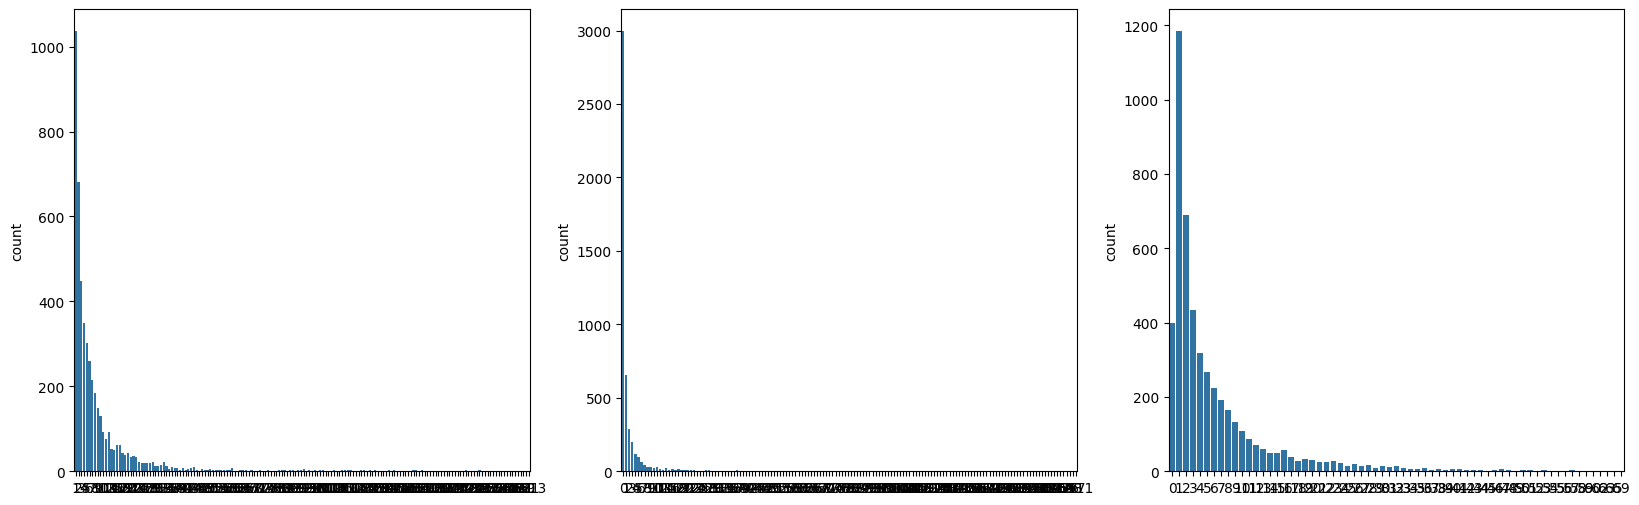

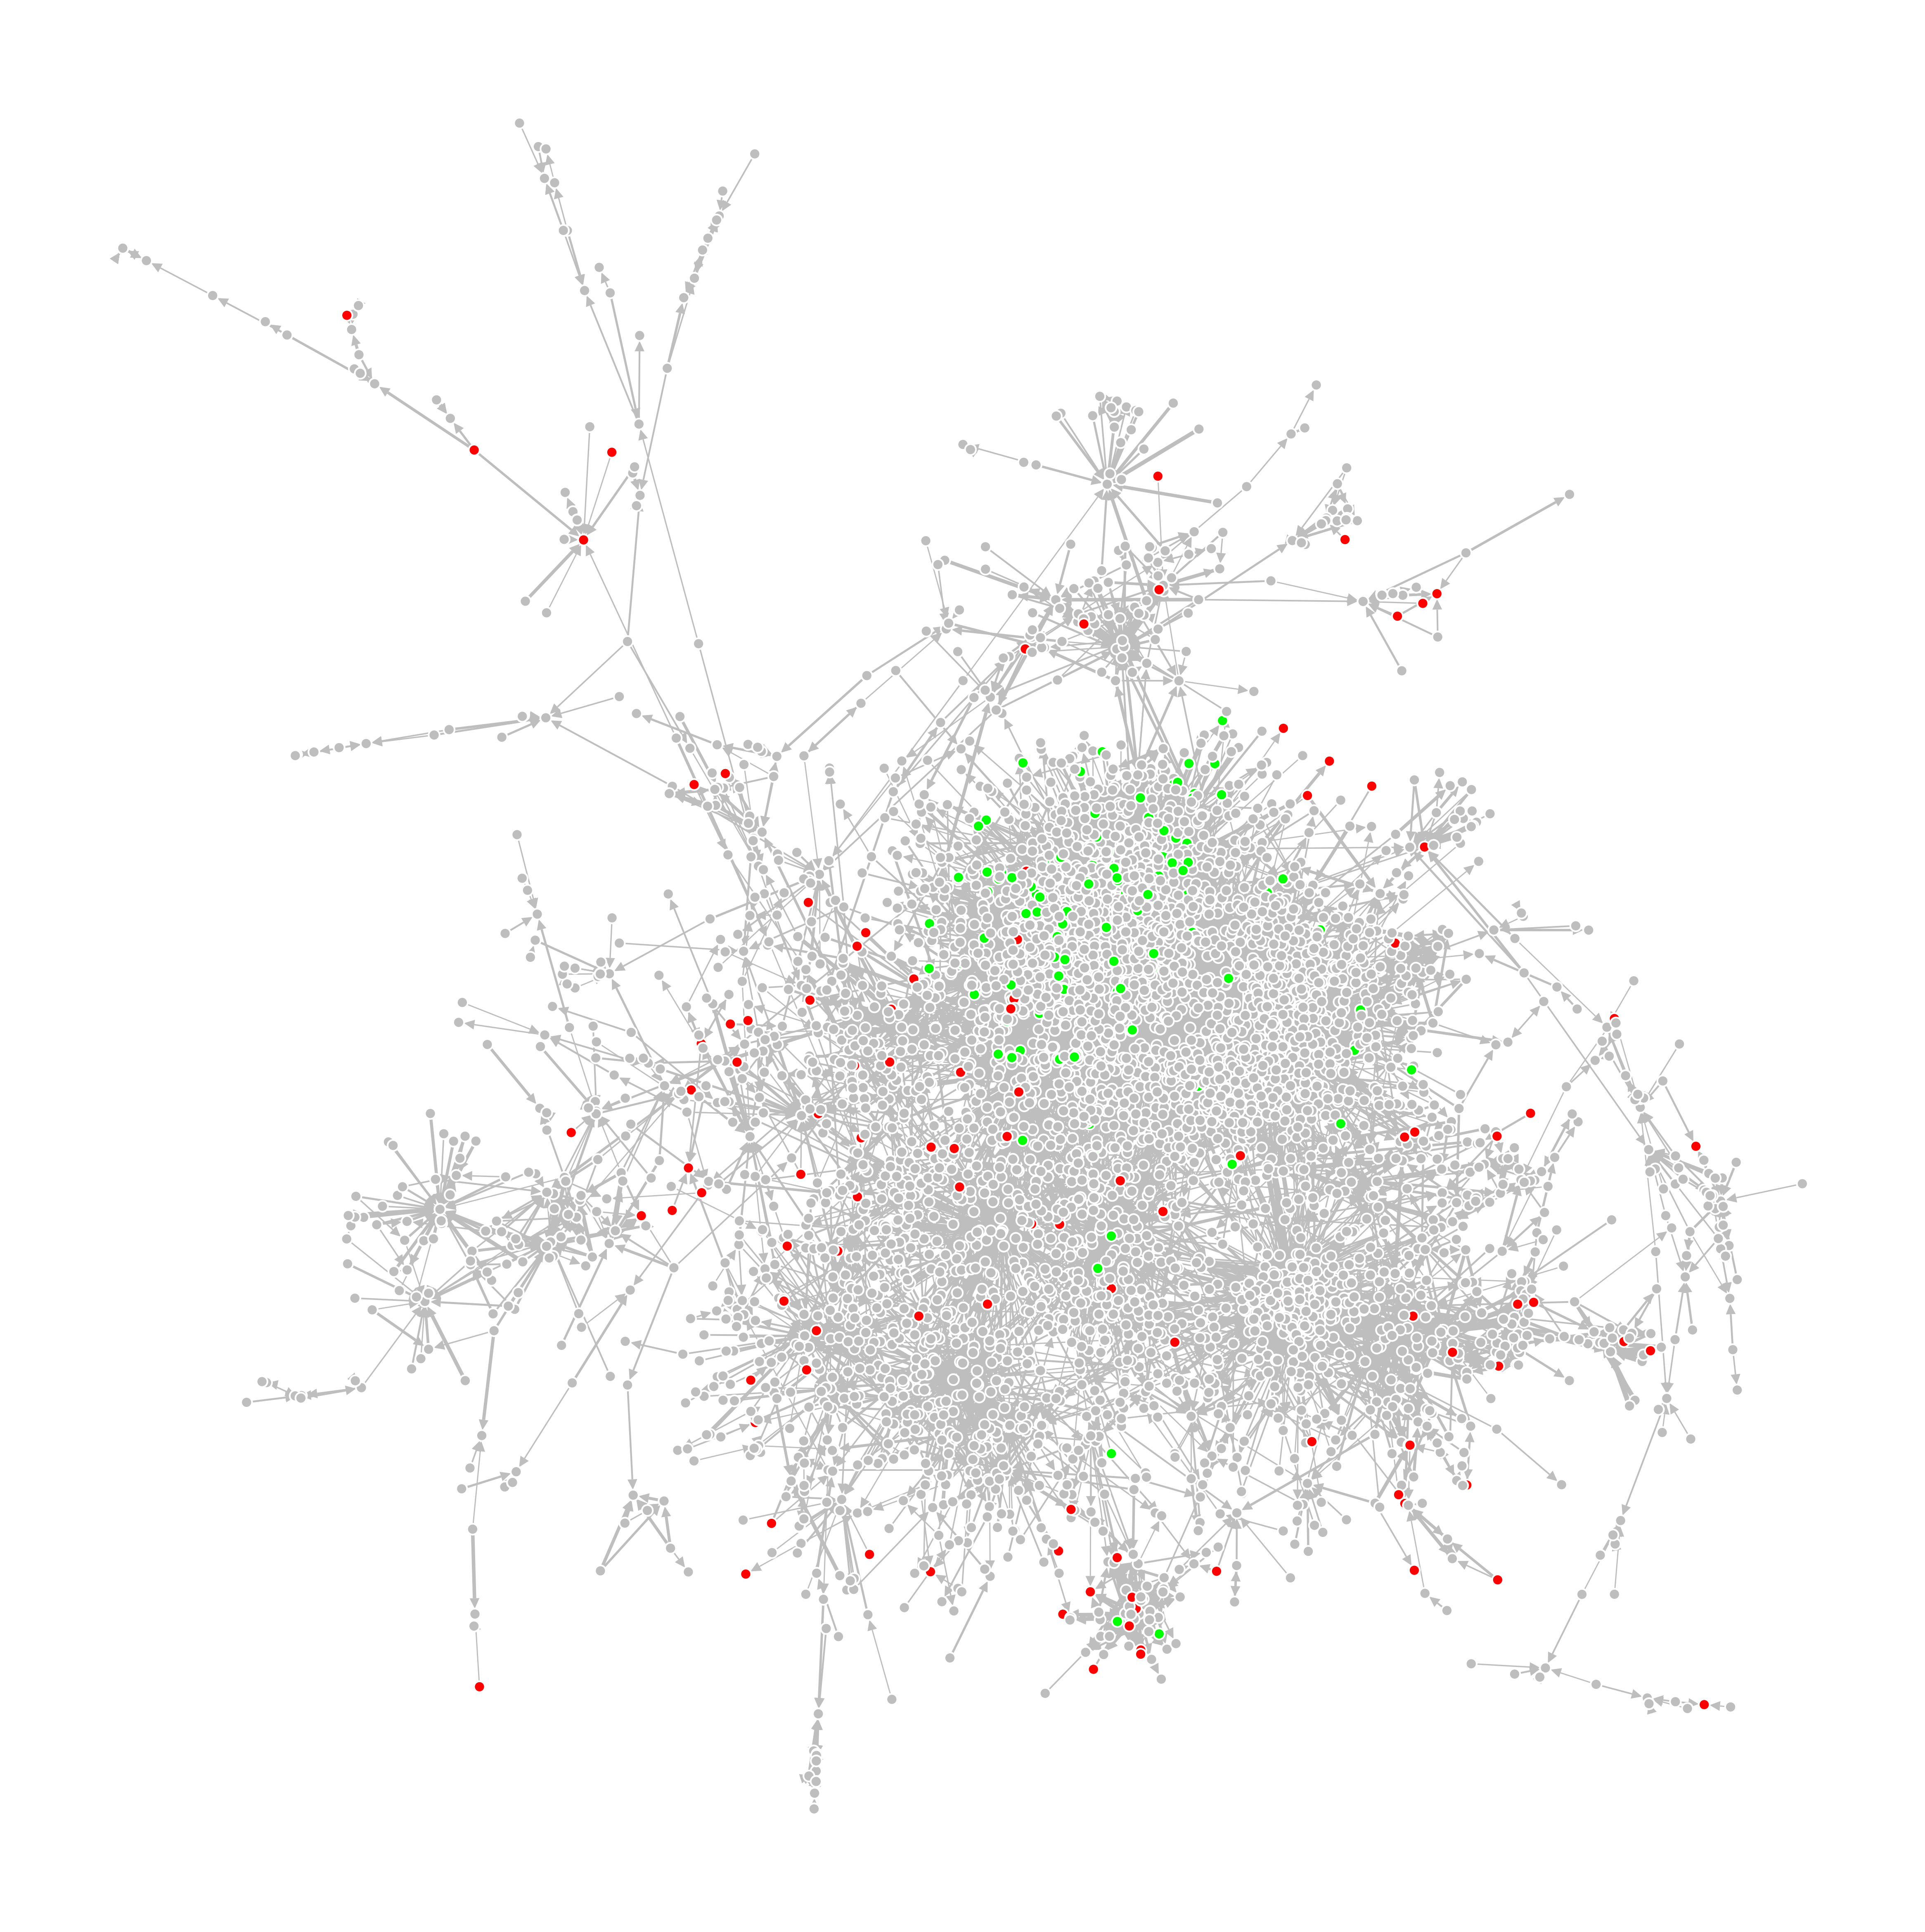

gab
IGRAPH DNW- 21972 362479 -- 
+ attr: label (v), name (v), weight (e)


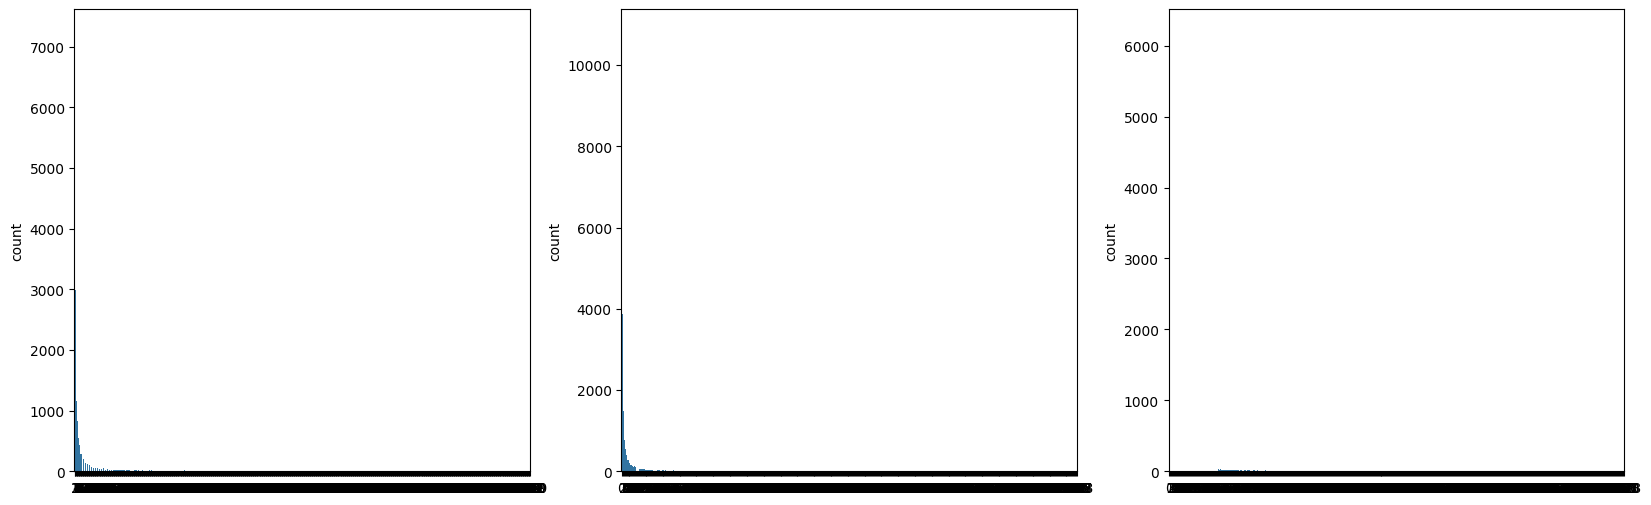

In [ ]:
for d in datasets:
    print(d)
    largest_weakly_component = largest_component_dict[d]
    print(largest_weakly_component.summary())

    _, degree_counts = np.unique(g.degree(), return_counts=True)

    fig, axs = plt.subplots(1, 3, figsize=(20,6))
    sns.countplot(x=largest_weakly_component.degree(), ax=axs[0])
    sns.countplot(x=largest_weakly_component.degree(mode='in'), ax=axs[1])
    sns.countplot(x=largest_weakly_component.degree(mode='out'), ax=axs[2])
    # axs[2].set_xticks(ticks=axs[2].get_xticks(), labels=ticks=axs[2].get_xticklabls(), rotation=0)
    plt.show()

    plot_igraph(largest_weakly_component, title=f'{dataset} largest connected component', **get_igraph_visual_style(largest_weakly_component, temperature=0.75))
    plt.show()

### Ego Network

In [395]:
order_k = 1
ego_network = g.neighborhood(vertices=labeled_nodes, order=order_k, mode='out')
set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
flattened_set = list({element for tupl in set_of_tuples for element in tupl})
ego_subgraph = g.subgraph(flattened_set)
ego_subgraph.vcount(), ego_subgraph.ecount()

(1316, 14483)

In [396]:
visual_style = {}
visual_style['vertex_size'] = 0.5
visual_style['vertex_label'] = None
visual_style['layout'] = ego_subgraph.layout('kk')
# visual_style['bbox'] = (300, 300)
visual_style['margin'] = 20
# kwds['target'] = ax
visual_style['edge_color'] = 'black'

In [399]:
title = f'{dataset} ego network of labeled nodes (order of {order_k}) with min edge weight: 2'

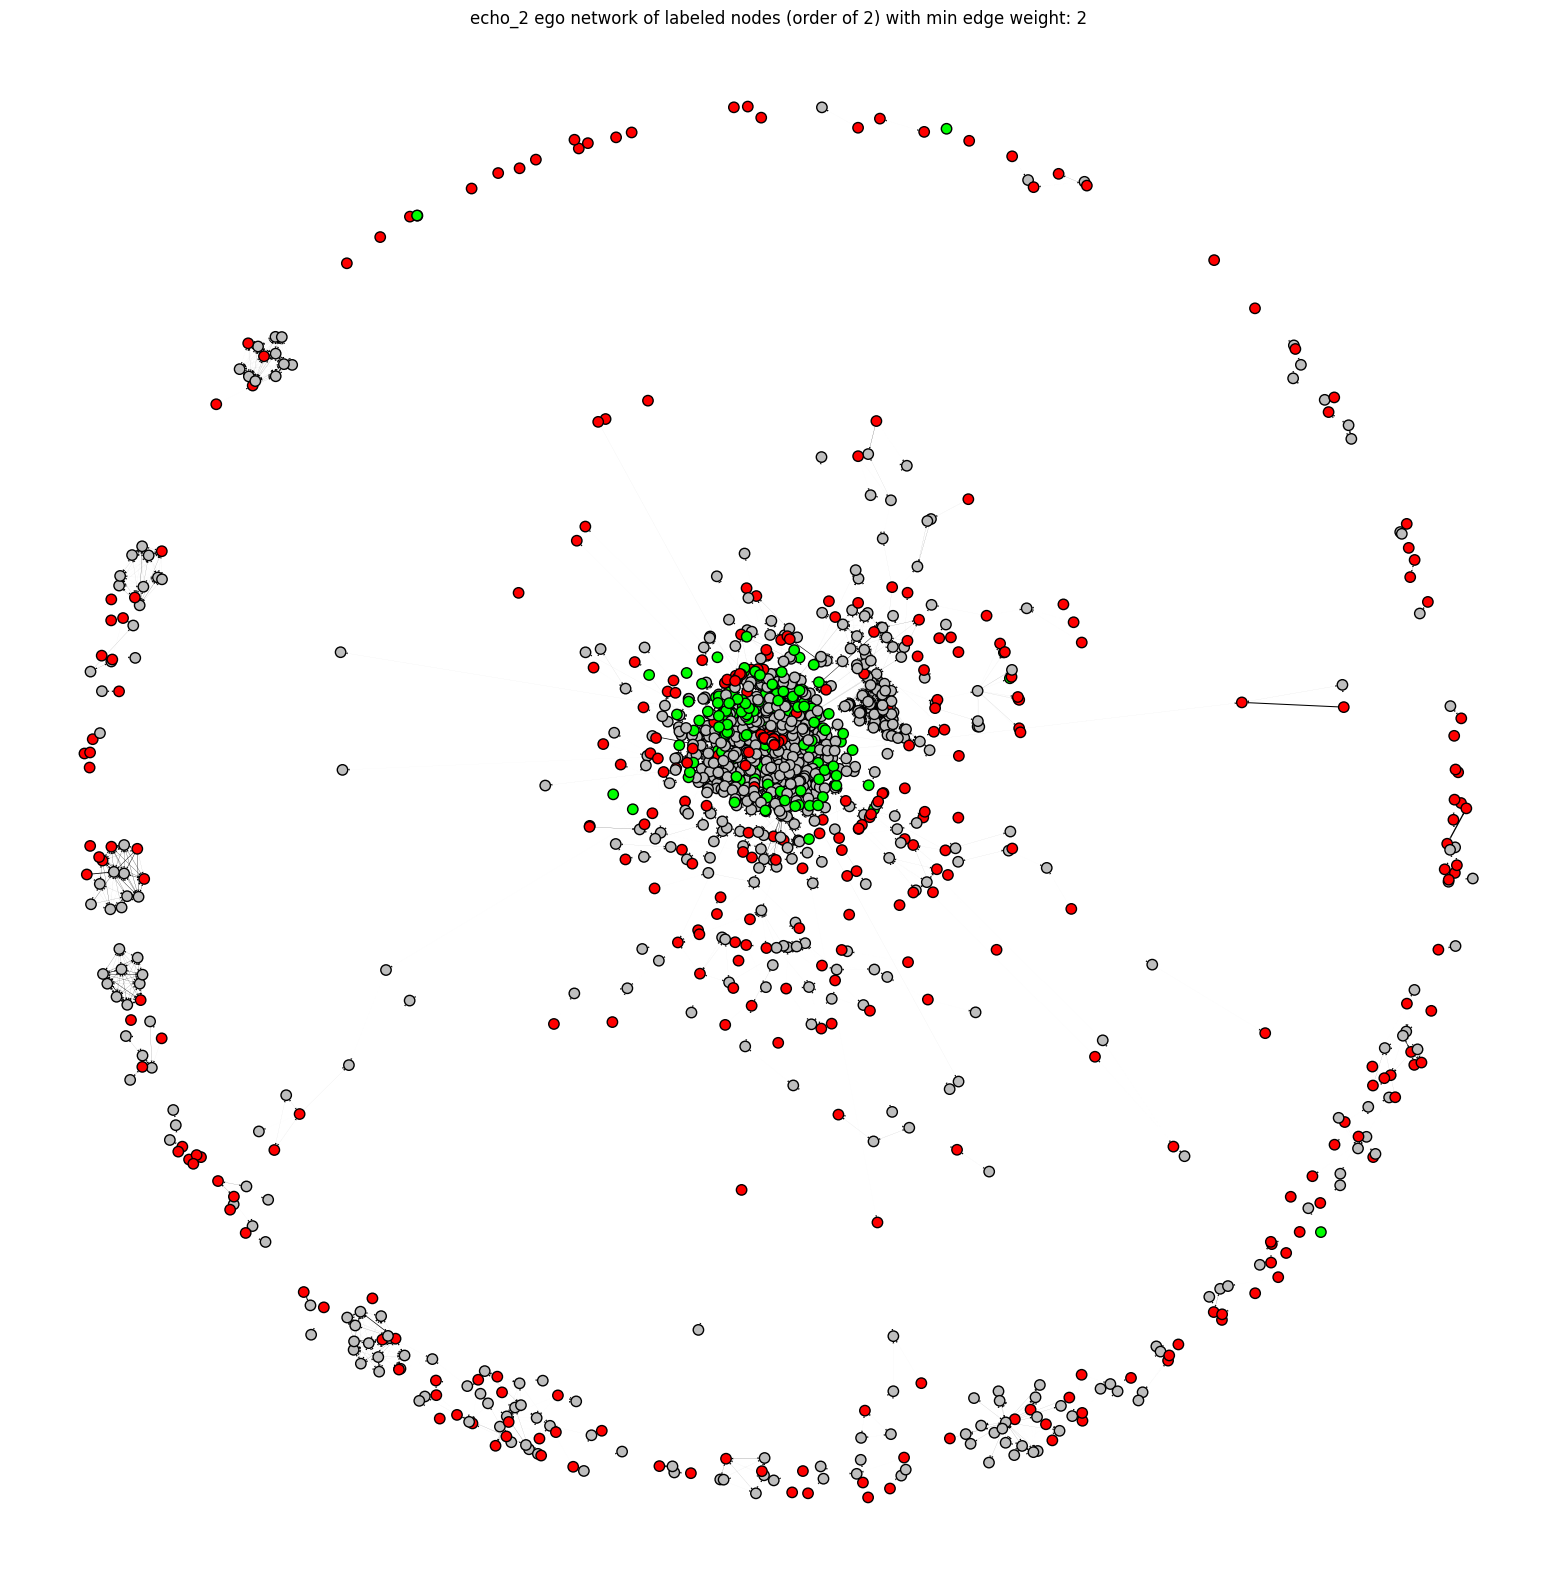

In [397]:
plot_igraph(ego_subgraph, title, **visual_style)

In [100]:
layout = g.layout_fruchterman_reingold()

node_labels = [y.loc[e['name']] if e['name'] in y.index else -1 for e in g.vs]
g.vs['label'] = node_labels 

label_color_map = {
    0: 'red',
    1: 'green',
    -1: 'gray'
}
node_colors = [label_color_map[label] for label in g.vs['label']]
node_names = [name for name in g.vs['name']]


In [105]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 10))
edge_widths = scaler.fit_transform(np.array([w for w in g.es['weight']]).reshape(-1, 1)).flatten()

g.es['width'] = [weight / max_weight * 10 for weight in g.es['weight']]  

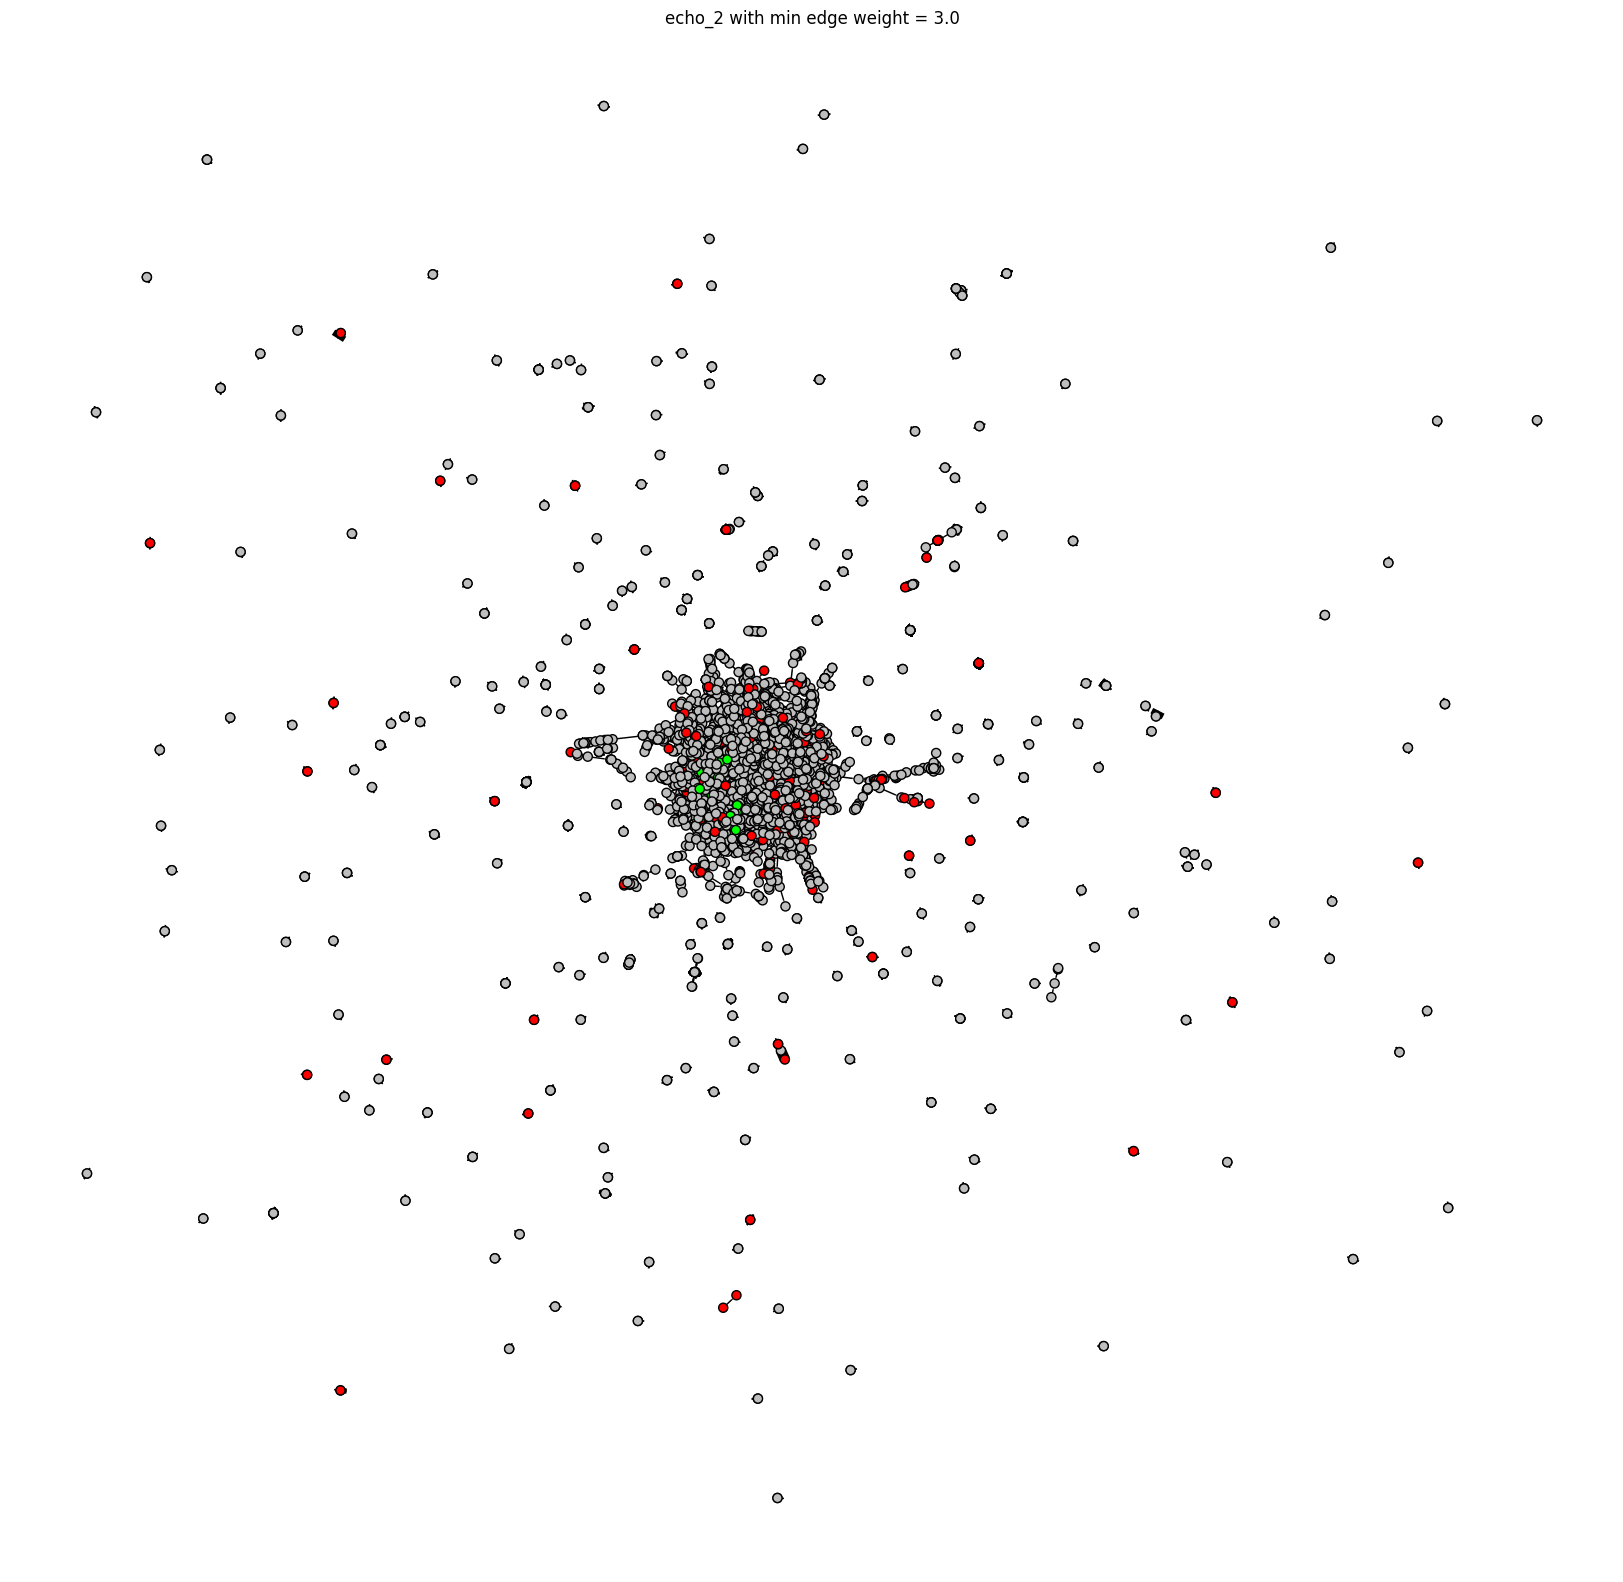

In [109]:
fig, ax = plt.subplots(figsize=(40,20))
save_dir = 'detection/experiments/sna'
title = f'{dataset} with min edge weight = {min_weight}'
save_path = os.path.join(save_dir, f'{title}.pdf')
plt.title(title)
ig.plot(g, layout=layout, target=ax, vertex_size=0.5, vertex_color=node_colors, edge_color='black', bbox=(0, 0, 1000, 1000), vertex_label=None, edge_width=edge_widths)
# ig.plot(g, layout=layout, target=ax, margin=50, vertex_color=node_colors, edge_color='black', bbox=(0, 0, 1000, 1000), edge_width=edge_widths)
plt.show()

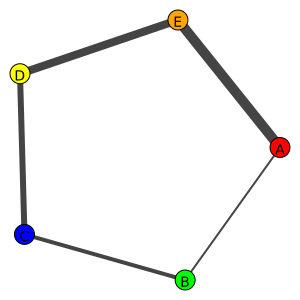

In [154]:
import igraph as ig
import matplotlib.pyplot as plt

# Step 1: Create a weighted graph with labels
g = ig.Graph(directed=False)

# Add vertices
g.add_vertices(5)  # Adding 5 vertices for example

# Add edges with weights
g.add_edges([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])
g.es['weight'] = [1, 2, 3, 4, 5]  # Example weights

# Add labels to vertices
g.vs['label'] = ['A', 'B', 'C', 'D', 'E']  # Example labels

# Step 2: Assign colors based on labels
label_color_dict = {'A': 'red', 'B': 'green', 'C': 'blue', 'D': 'yellow', 'E': 'orange'}
g.vs['color'] = [label_color_dict[label] for label in g.vs['label']]

# Step 3: Adjust edge thickness based on weights (normalize for visualization)
max_weight = max(g.es['weight'])
g.es['width'] = [weight / max_weight * 10 for weight in g.es['weight']]  # Adjust multiplier as needed

# Step 4: Draw the graph
visual_style = {}
visual_style['vertex_size'] = 20
visual_style['vertex_color'] = g.vs['color']
visual_style['vertex_label'] = g.vs['label']
visual_style['edge_width'] = g.es['width']
visual_style['bbox'] = (300, 300)
visual_style['margin'] = 20

ig.plot(g, **visual_style)

## Clustering Coefficient

In [443]:
# Calculate clustering coefficient
# For directed graphs, you can use "average" to get the average of in and out coefficients
for name, g in igraph_dict.items():
    print(name)
    clustering_coefficient = g.transitivity_avglocal_undirected()
    print("Average Clustering Coefficient:", clustering_coefficient)

echo_2
Average Clustering Coefficient: 0.21800978211656658
gab
Average Clustering Coefficient: 0.4297567690084801
parler
Average Clustering Coefficient: 0.30713684638318595


In [467]:
for name, g in filtered_igraph_dict.items():
    print(name)
    clustering_coefficient = g.transitivity_avglocal_undirected()
    print("Average Clustering Coefficient:", np.round(clustering_coefficient, 3))

echo_2
Average Clustering Coefficient: 0.261
gab
Average Clustering Coefficient: 0.468
parler
Average Clustering Coefficient: 0.241


## Connected Components

In [444]:
# Find weakly connected components
for name, g in igraph_dict.items():
    print(name)
    weakly_connected_components = g.components(mode="weak")
    print("Number of Weakly Connected Components:", len(weakly_connected_components))

    # Find strongly connected components
    strongly_connected_components = g.components(mode="strong")
    print("Number of Strongly Connected Components:", len(strongly_connected_components))

    print('Total number of Connected Components:', len(weakly_connected_components) + len(strongly_connected_components))

    # You can also explore the size of the largest component, or other properties
    largest_weakly_component = max(weakly_connected_components, key=len)
    print("Size of Largest Weakly Connected Component:", len(largest_weakly_component))

echo_2
Number of Weakly Connected Components: 680
Number of Strongly Connected Components: 5953
Total number of Connected Components: 6633
Size of Largest Weakly Connected Component: 10049
gab
Number of Weakly Connected Components: 281
Number of Strongly Connected Components: 52151
Total number of Connected Components: 52432
Size of Largest Weakly Connected Component: 83416
parler
Number of Weakly Connected Components: 8320
Number of Strongly Connected Components: 622583
Total number of Connected Components: 630903
Size of Largest Weakly Connected Component: 680470


In [469]:
# Find weakly connected components
d = {}
for name, g in filtered_igraph_dict.items():
    print(name)
    weakly_connected_components = g.components(mode="weak")
    print("Number of Weakly Connected Components:", len(weakly_connected_components))
    # Find strongly connected components
    strongly_connected_components = g.components(mode="strong")
    print("Number of Strongly Connected Components:", len(strongly_connected_components))

    print('Total number of Connected Components:', len(weakly_connected_components) + len(strongly_connected_components))

    # You can also explore the size of the largest component, or other properties
    largest_weakly_component = max(weakly_connected_components, key=len)
    print("Size of Largest Weakly Connected Component:", len(largest_weakly_component))
    
    d[name] = [len(weakly_connected_components), len(strongly_connected_components), len(weakly_connected_components) + len(strongly_connected_components), len(largest_weakly_component)]

echo_2
Number of Weakly Connected Components: 361
Number of Strongly Connected Components: 4973
Total number of Connected Components: 5334
Size of Largest Weakly Connected Component: 4929
gab
Number of Weakly Connected Components: 178
Number of Strongly Connected Components: 16352
Total number of Connected Components: 16530
Size of Largest Weakly Connected Component: 21972
parler
Number of Weakly Connected Components: 657
Number of Strongly Connected Components: 210172
Total number of Connected Components: 210829
Size of Largest Weakly Connected Component: 204284


In [474]:
pd.DataFrame.from_dict(d)

echo_2    gab  parler
0     361    178     657
1    4973  16352  210172
2    5334  16530  210829
3    4929  21972  204284

In [445]:
# Find weakly connected components
for name, g in igraph_dict.items():
    print(name)
    degrees = g.degree()

    # Count the number of vertices with degree 0 (singletons)
    singletons = degrees.count(0)

    print("Number of singletons:", singletons)

echo_2
Number of singletons: 589
gab
Number of singletons: 0
parler
Number of singletons: 6534


## Power Law

In [216]:
degrees = g.degree()
in_degree_lst = g.degree(mode='in')
out_degree_lst = g.degree(mode='out')

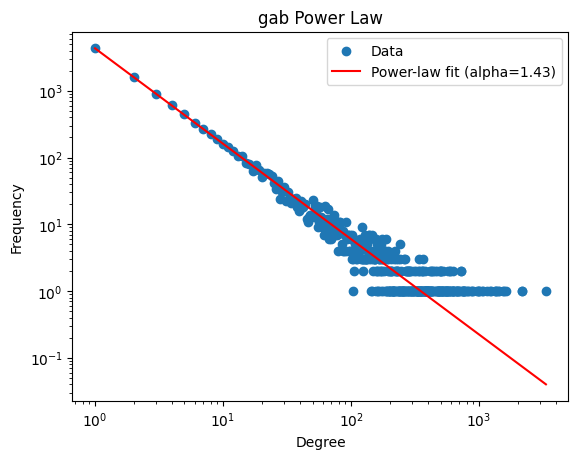

(4331.211301925948, 1.428953015234786)

In [217]:
alpha, C = calc_power_law_exp(degrees)
C, alpha

## Centrality Measures

In [ ]:
# Centrality Measures
for name, g in filtered_igraph_dict.items():
    print(name)
    degree_centrality = g.degree()
    betweenness_centrality = g.closeness()
    closeness_centrality = g.betweenness()

    mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality = np.mean([degree_centrality, betweenness_centrality, closeness_centrality], axis=1)
    print(mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality)

In [ ]:
# Check if the graph is connected
if g.is_connected():
    avg_path_length = g.average_path_length()
    print("Average shortest path length:", avg_path_length)
else:
    print("Graph is not connected. Average path length is undefined for the whole graph.")
#     for c in g.components(mode="strong"):
#         h = g.subgraph(c)
#         if h.vcount() < 2:
#             continue
#         print(h.vcount(), h.ecount())
#         # Centrality Measures
#         degree_centrality = h.degree()
#         betweenness_centrality = h.closeness()
#         closeness_centrality = h.betweenness()

#         mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality = np.mean([degree_centrality, betweenness_centrality, closeness_centrality], axis=1)
#         print(mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality)

## Truth Social

In [57]:
dataset = 'truth'

In [220]:
min_weight = 1

In [221]:
# truth_reposts_graph = get_reposts_graph('truth')
truth_reposts_path = path_conf['truth']['reposts']
truth_reposts_df = pd.read_csv(reposts_path, sep='\t', names=['source', 'target', 'retruths_list', 'weight'], skiprows=1)
truth_filtered_reposts_df = truth_reposts_df.query('`weight`>@min_weight and source!=target')
truth_filtered_reposts_df

source  target                                      retruths_list   
3           24      22  [13884, 13890, 13871, 13876, 13877, 13878, 138...  \
4           24      23  [13906, 13905, 13902, 13926, 13925, 13903, 138...   
5           26      27                                           [68, 26]   
6           27      26                                 [2473, 2474, 2569]   
8           27     105                                       [1569, 2664]   
...        ...     ...                                                ...   
105438   22008     416                           [975185, 975364, 975206]   
105441   22008     731           [975280, 975328, 975400, 975404, 975437]   
105443   22008    2843                                   [975318, 975484]   
105445   22011      27  [976944, 977200, 977041, 976980, 977117, 97713...   
105446   22014      27  [977714, 977799, 977543, 977719, 977743, 97761...   

        weight  
3           19  
4           23  
5            2  
6            3  
8            2  
...        ...  
105438       3  
105441       5  
105443       2  
105445      43  
105446      29  

[24802 rows x 4 columns]

In [222]:
g = ig.Graph.TupleList(truth_filtered_reposts_df.values, directed=True, edge_attrs="weight")
print(g.vcount(), g.ecount())
g.vs.select(_degree=0).delete()
g.simplify(multiple=True, loops=True)
print(g.vcount(), g.ecount())

4374 24802
4374 24802


### Plot

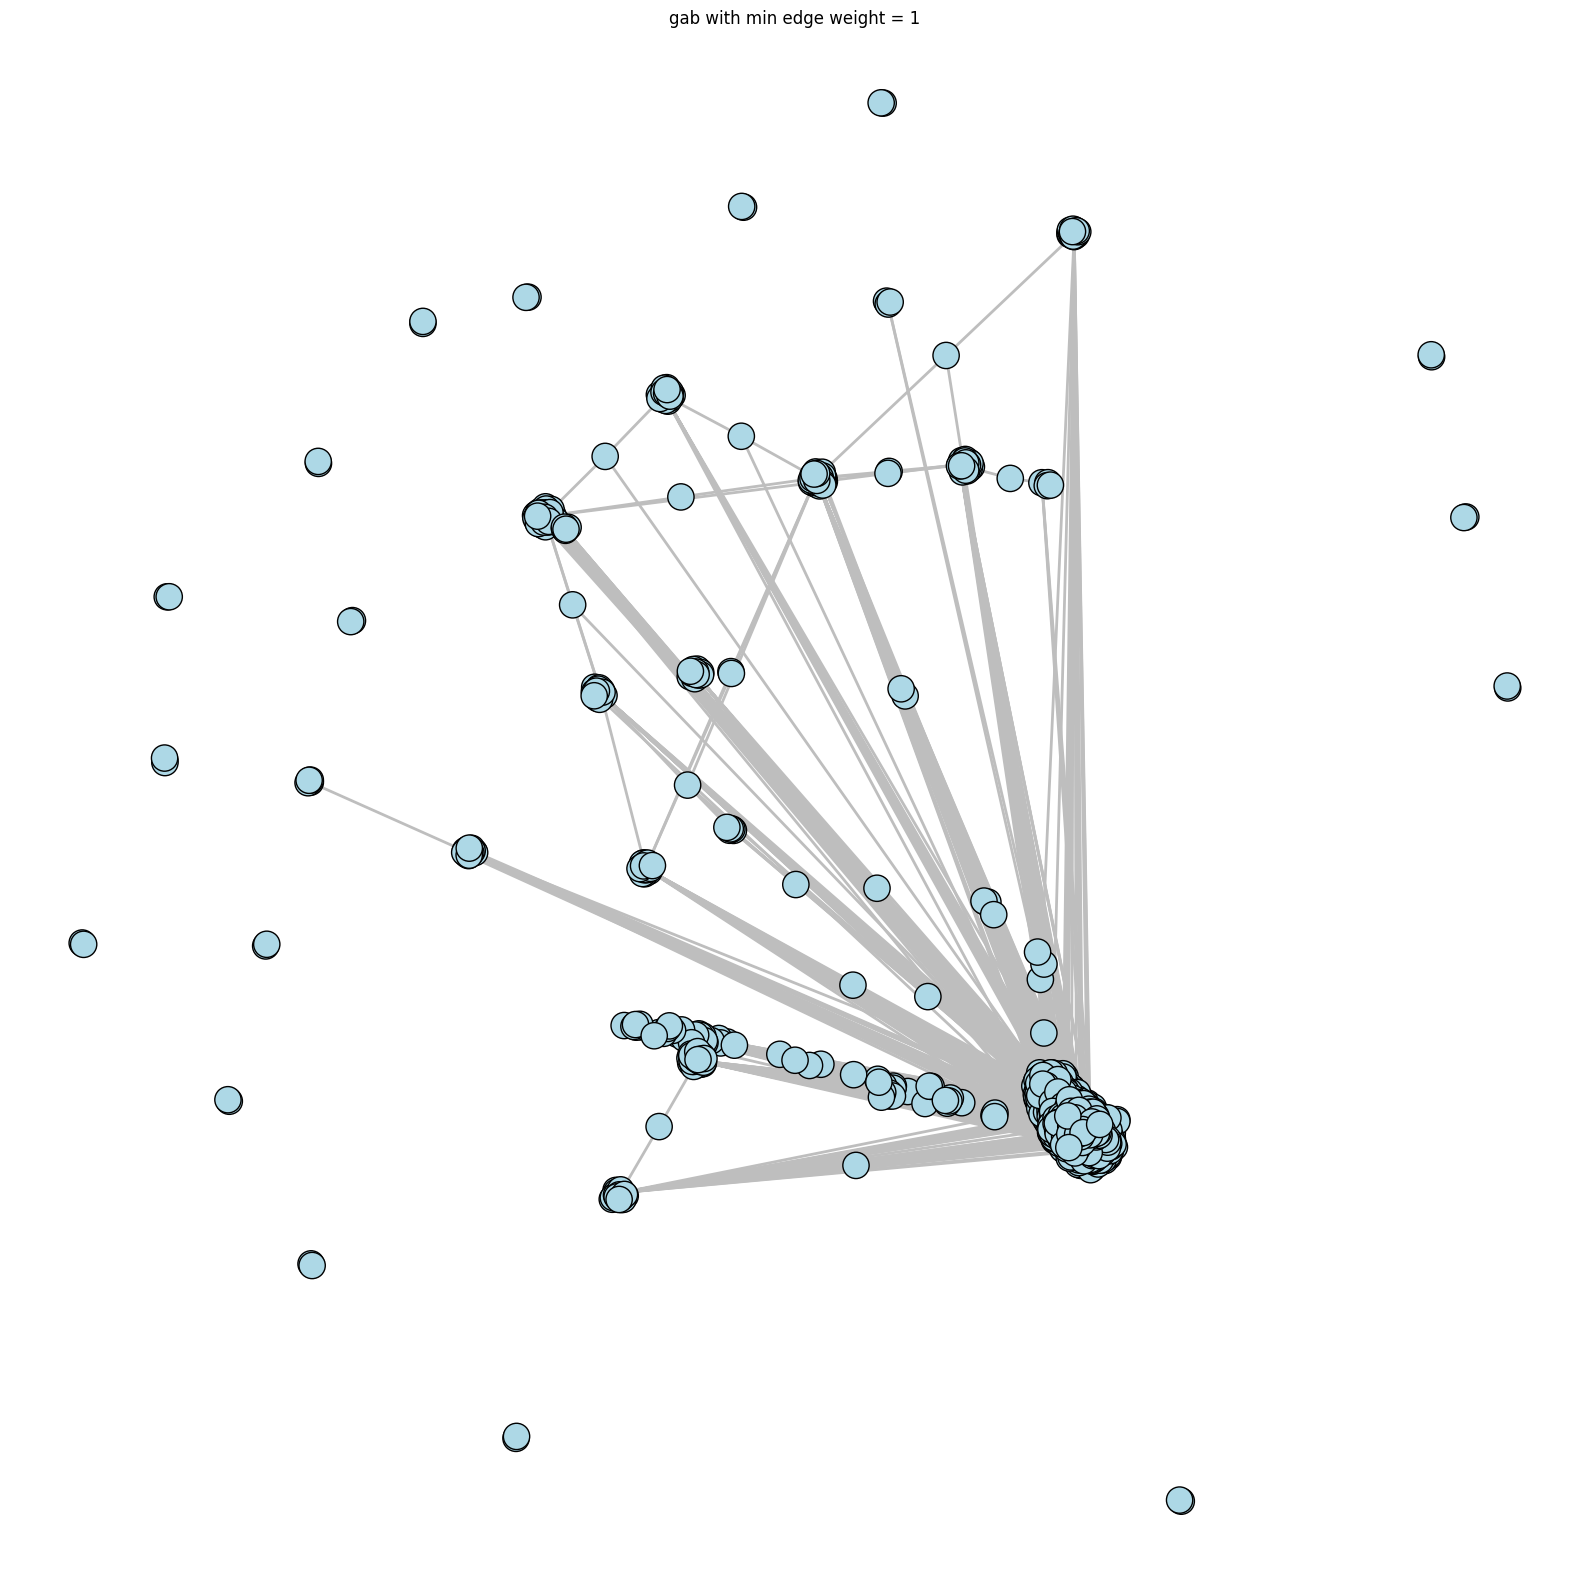

In [223]:
fig, ax = plt.subplots(figsize=(40,20))
save_dir = 'detection/experiments/sna'
title = f'{dataset} with min edge weight = {min_weight}'
save_path = os.path.join(save_dir, f'{title}.pdf')
plt.title(title)
ig.plot(g, target=ax, arrow_size=0.5, edge_size=1, vertex_size=7, vertex_color='lightblue', edge_color='gray', bbox=(0, 0, 600, 600))
plt.show()

### Clustering Coefficient

In [224]:
# Calculate clustering coefficient
# For directed graphs, you can use "average" to get the average of in and out coefficients
clustering_coefficient = g.transitivity_avglocal_undirected()
print("Average Clustering Coefficient:", clustering_coefficient)

Average Clustering Coefficient: 0.09451424659873649


### Connected Components

In [225]:
# Find weakly connected components
weakly_connected_components = g.components(mode="weak")
print("Number of Weakly Connected Components:", len(weakly_connected_components))

# Find strongly connected components
strongly_connected_components = g.components(mode="strong")
print("Number of Strongly Connected Components:", len(strongly_connected_components))

print('Total number of Connected Components:', len(weakly_connected_components) + len(strongly_connected_components))

# You can also explore the size of the largest component, or other properties
largest_weakly_component = max(weakly_connected_components, key=len)
print("Size of Largest Weakly Connected Component:", len(largest_weakly_component))

Number of Weakly Connected Components: 18
Number of Strongly Connected Components: 4316
Total number of Connected Components: 4334
Size of Largest Weakly Connected Component: 4339


In [231]:
degrees = g.degree()

# Count the number of vertices with degree 0 (singletons)
singletons = degrees.count(0)

print("Number of singletons:", singletons)

Number of singletons: 0


### Power Law

In [764]:
degrees = g.degree()
in_degree_lst = g.degree(mode='in')
out_degree_lst = g.degree(mode='out')
degrees[0], degrees[0], degrees[0]

(108, 108, 108)

In [765]:
# Replace 'degrees' with your actual data containing node degrees
def calc_power_law_exp(degrees):

    # Convert the degrees to numpy arrays
    x = np.array(degrees)

    # Count the frequency of each degree
    degree_counts = np.bincount(x)

    # Remove the zero-degree entries
    x = np.nonzero(degree_counts)[0]
    y = degree_counts[x]

    # Perform the curve fitting
    popt, _ = curve_fit(power_law, x, y)
    alpha, C = popt
    
    plt.scatter(x, y, label="Data")
    plt.plot(x, power_law(x, alpha, C), color='red', label=f"Power-law fit (alpha={alpha:.2f})")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f'{dataset} Power Law')
    plt.savefig(f'detection/experiments/{dataset}_power_law.png', dpi=300)
    plt.show()

    return alpha, C

In [766]:
alpha, C = calc_power_law_exp(degrees)
C, alpha

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

### Centrality Measures

In [230]:
np.mean(g.degree()), np.mean(g.closeness()), np.mean(g.betweenness())

(11.340649291266574, 0.30683594951530063, 177.37379972565122)

In [111]:
# Centrality Measures
degree_centrality = g.degree()
betweenness_centrality = g.closeness()
closeness_centrality = g.betweenness()

mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality = np.mean([degree_centrality, betweenness_centrality, closeness_centrality], axis=1)
mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality

(8.4282011404873, 0.3454157215965223, 6.03784344219803)

In [114]:
# Check if the graph is connected
if g.is_connected():
    avg_path_length = g.average_path_length()
    print("Average shortest path length:", avg_path_length)
else:
    print("Graph is not connected. Average path length is undefined for the whole graph.")
    for c in g.components(mode="strong"):
        h = g.subgraph(c)
        if h.vcount() < 2:
            continue
        print(h.vcount(), h.ecount())
        # Centrality Measures
        degree_centrality = h.degree()
        betweenness_centrality = h.closeness()
        closeness_centrality = h.betweenness()

        mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality = np.mean([degree_centrality, betweenness_centrality, closeness_centrality], axis=1)
        print(mean_degree_centrality, mean_betweenness_centrality, mean_closeness_centrality)

Graph is not connected. Average path length is undefined for the whole graph.
2 2
2.0 1.0 0.0
2 2
2.0 1.0 0.0
2 2
2.0 1.0 0.0
2 2
2.0 1.0 0.0
2 2
2.0 1.0 0.0
2 2
2.0 1.0 0.0
3 4
2.6666666666666665 0.7777777777777777 0.6666666666666666


# Degroots Diffusion

In [40]:
import numpy as np
import networkx as nx
from scipy import sparse


def fit_degroots_diffusion(nx_network, seed_hate_users, self_loops_dict,
                           iterations=2, initial_belief=1, fix_seed_haters_belief=False, verbose=False):
    """
    running a diffusion model as suggested in https://github.com/manoelhortaribeiro/HatefulUsersTwitter/blob/master/preprocessing/5_get_diffusion_graph.py

    :param nx_network: networkX object. The social network to run the model over
    :param seed_hate_users: list or set. the seed (original) hate users
    :param self_loops_dict: dict. a dictionary where key is a username and value is the weight of self loop (this is
    the total number of posts per user)
    :param iterations: int. Default: 2. number of iterations to run the difussion mode (usually in te [1,5] range)
    :param initial_belief: float. Default: 1. the initial belief values of the seed hate users. In most cases this is 1
    :param fix_seed_haters_belief: bool. Default: False. whether or not to set the value of the hate users as the
    initial_belief. This "help" propogate the hate and keep the seed hate users as haters over all iterations
    :param verbose: bool. whether to print information along the prccess
    :return: dict. a dictionary where key is the username and value is the belief value of the user at the end of the
    process

    Example:
    input_for_networkx = [('A', 'B', 4),
                          ('B', 'C', 3),
                          ('C', 'A', 1), ('C', 'B', 6),
                          ('D', 'B', 2), ('D', 'C', 4)]
    social_network = nx.DiGraph()
    social_network.add_weighted_edges_from(input_for_networkx)
    seed_hate_users = ('A', 'B')
    self_loops_dict = {'A': 6, 'B': 7, 'C': 0, 'D': 2}
    iterations=2
    initial_belief = 1.0
    fix_seed_haters_belief = False
    final_belief_dict = fit_degroots_diffusion(social_network, seed_hate_users, self_loops_dict, iterations,
                                               initial_belief, fix_seed_haters_belief)
    "Out of the 2 seed hate users, 2 are found in the network"
    final_belief_dict
    {'A': 0.8800000000000001, 'B': 0.7900000000000001, 'C': 0.7428571428571429, 'D': 0.7375}
    """
    # NOTE!!! There are 1994 hate-users which ARE NOT in the network (since they only commented and did not echo anyone)

    hate_users_in_network = [h for h in seed_hate_users if h in nx_network.nodes()]
    not_hate_users = list(set(nx_network.nodes()).difference(set(hate_users_in_network)))
    node_list = hate_users_in_network + not_hate_users
    # inverse the network, since diffusion moves from the writter to the reader + adding self-loop
    social_network_reversed = nx_network.reverse(copy=True)
    for n in social_network_reversed.nodes():
        if n in self_loops_dict:
            social_network_reversed.add_edge(n, n, weight=self_loops_dict[n])
        else:
            social_network_reversed.add_edge(n, n, weight=0)
    # the (i, j) place will have the weight of the edge between node i and j
    transition_matrix = nx.adjacency_matrix(social_network_reversed, nodelist=node_list).asfptype()
    # we need to transpose the matrix since now each column represents the INPUT arrows to each node and is sum to 1
    # it is a bit confusing, but take a look at the example above and then it will make sense
    transition_matrix = transition_matrix.transpose(copy=True)

    # normalization, the short way...
    rows_sum = np.sum(transition_matrix, axis=1).tolist()
    inverse_row_sum = [1 / i[0] if i[0] > 0 else 0 for i in rows_sum]
    inverse_row_sum_as_csr = sparse.csr_matrix(inverse_row_sum).transpose()
    transition_matrix = transition_matrix.multiply(inverse_row_sum_as_csr)

    beliefs = np.zeros(len(node_list))
    beliefs[:len(hate_users_in_network)] = initial_belief

    for _ in range(iterations):
        out = transition_matrix.dot(beliefs)
        beliefs = out
        # in case fix_seed_haters_belief is set to True, in each cycle the beliefs of the haters is set back to 1
        if fix_seed_haters_belief:
            beliefs[:len(hate_users_in_network)] = initial_belief
    final_beliefs_dict = dict()
    for node, belief in zip(node_list, beliefs):
        final_beliefs_dict[node] = float(belief)
    # sorting the dict by value
    final_beliefs_dict = dict(sorted(final_beliefs_dict.items(), key=lambda x: x[1], reverse=True))
    if verbose:
        print(f"Out of the {len(seed_hate_users)} seed hate users, {len(hate_users_in_network)} are in the network")
    return final_beliefs_dict


In [20]:
import pandas as pd
import numpy as np
import igraph as ig
import pickle

def get_doc_vectors(dataset):
    if dataset in doc_vectors_dict:
        return doc_vectors_dict[dataset]
    doc_vectors = pickle.load(open(path_conf[dataset]['doc_vectors'], "rb"))
    doc_vectors_dict[dataset] = doc_vectors
    return doc_vectors

def get_user_labels(dataset):
    if dataset in labeled_nodes_dict:
        return labeled_nodes_dict[dataset]
    user2label_path = user_level_conf[dataset]["data_path"]
    sep = ","
    if user2label_path.endswith("tsv"):
        sep = "\t"
    y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
    y.index = y.index.astype('str')
    labeled_nodes_dict[dataset] = y
    return y

def get_reposts_graph(dataset, min_weight=1):
    if dataset in graphs_dict:
        g = graphs_dict[dataset]
        filtered_edges = g.es.select(weight_ge=min_weight)
        return g.subgraph_edges(filtered_edges)
    reposts_path = path_conf[dataset]['reposts']
    if reposts_path.endswith('.txt'):
        reposts_df = pd.read_csv(reposts_path, sep='\t', header=None, names=['source', 'target', 'weight'])
    elif reposts_path.endswith('.tsv'):
        if dataset == 'truth':
            pd.read_csv(reposts_path, sep='\t', names=['source', 'target', 'retruths_list', 'weight'], skiprows=1)
        else:
            reposts_df = pd.read_csv(reposts_path, sep='\t', names=['source', 'target', 'weight'], skiprows=1)
    elif reposts_path.endswith('.csv'):
        reposts_df = pd.read_csv(reposts_path, header=None, names=['source', 'target', 'weight'])
    else:
        reposts_edge_dict = pickle.load(open(reposts_path, "rb"))
        reposts_edge_list = [[k[0], k[1], v] for k,v in tqdm(reposts_edge_dict.items())]
        reposts_df = pd.DataFrame(reposts_edge_list, columns=['source', 'target', 'weight'])
    reposts_df['source'] = reposts_df['source'].astype(str)
    reposts_df['target'] = reposts_df['target'].astype(str)
    reposts_dict[dataset] = reposts_df
    edges = [tuple(x) for x in reposts_df[['source', 'target', 'weight']].values]
    g = ig.Graph.TupleList(edges, edge_attrs=['weight'], directed=True)    
    y = get_user_labels(dataset)
    g.vs['label'] = [y.loc[e['name']] if e['name'] in y.index else -1 for e in g.vs]
    # g.vs.select(_degree=0).delete()
    g.simplify(multiple=True, loops=True, combine_edges='sum')
    g['name'] = dataset
    graphs_dict[dataset] = g
    filtered_edges = g.es.select(weight_ge=min_weight)
    return g.subgraph_edges(filtered_edges)

def get_largest_weak_cc(g):
    # Assuming 'g' is your igraph Graph
    components = g.components(mode='WEAK')  # Find weakly connected components
    return components.giant()

def get_graph_with_docs(dataset):
    if dataset in graphs_with_docs_dict:
        return graphs_with_docs_dict[dataset]
    G = graphs_dict.get(dataset, get_reposts_graph(dataset))
    doc_vectors = doc_vectors_dict.get(dataset, get_doc_vectors(dataset))
    H = G.subgraph(doc_vectors).copy()
    graphs_with_docs_dict[dataset] = H
    return H

def get_label_count_and_percent(dataset):
    G = get_graph_with_docs(dataset)
    y = get_user_labels(dataset)
    ngbrs_labels = {n : np.array([y[ngbr] if ngbr in y.index else 2 for ngbr in G.neighbors(n)]) for n in tqdm(G.nodes())}
    ngbrs_labels_count = {k: Counter(v) for k,v in ngbrs_labels.items()}
    label_count_df = pd.DataFrame.from_dict(ngbrs_labels_count, orient='index').fillna(0).astype(int).sort_index(axis=0).sort_index(axis=1)
    return label_count_df

def power_law(x, alpha, C):
    return C * x**(-alpha)

def get_labeled_nodes(dataset: str = '', g: ig.Graph = None):
    if dataset == '' and g is not None:
        dataset = g['name']
    elif g is None and dataset!='':
        g = graphs_dict[dataset]
    else:
        raise ValueError("Both @dataset and @g can't be empty")
    y = get_user_labels(dataset)
    labeled_nodes = g.vs.select(lambda v:  v['label'] != -1)
    return labeled_nodes

# Replace 'degrees' with your actual data containing node degrees
def calc_power_law_exp(degrees):

    # Convert the degrees to numpy arrays
    x = np.array(degrees)

    # Count the frequency of each degree
    degree_counts = np.bincount(x)

    # Remove the zero-degree entries
    x = np.nonzero(degree_counts)[0]
    y = degree_counts[x]

    # Perform the curve fitting
    popt, _ = curve_fit(power_law, x, y)
    alpha, C = popt
    
    plt.scatter(x, y, label="Data")
    plt.plot(x, power_law(x, alpha, C), color='red', label=f"Power-law fit (alpha={alpha:.2f})")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f'{dataset} Power Law')
    plt.savefig(f'detection/experiments/{dataset}_power_law.png', dpi=300)
    plt.show()

    return alpha, C

def get_ego_subgraph(g, vertices, order_k = 1):
    ego_network = g.neighborhood(vertices=vertices, order=order_k, mode='out')
    set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
    flattened_set = list({element for tupl in set_of_tuples for element in tupl})
    ego_subgraph = g.subgraph(flattened_set)
    return ego_subgraph